https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-and-dataset.html


# Sentiment Analysis: Using Recurrent Neural Networks
:label:`sec_sentiment_rnn` 


Like word similarity and analogy tasks,
we can also apply pretrained word vectors
to sentiment analysis.
Since the IMDb review dataset
in :numref:`sec_sentiment`
is not very big,
using text representations
that were pretrained
on large-scale corpora
may reduce overfitting of the model.
As a specific example
illustrated in :numref:`fig_nlp-map-sa-rnn`,
we will represent each token
using the pretrained GloVe model,
and feed these token representations
into a multilayer bidirectional RNN
to obtain the text sequence representation,
which will
be transformed into 
sentiment analysis outputs :cite:`Maas.Daly.Pham.ea.2011`.
For the same downstream application,
we will consider a different architectural
choice later.

:label:`fig_nlp-map-sa-rnn`


nlp-map-sa-rnn.svg

In [ ]:
!pip install d2l==0.17.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 110 kB/s 
     |████████████████████████████████| 11.6 MB 59.7 MB/s 
     |████████████████████████████████| 20.6 MB 1.2 MB/s 
     |████████████████████████████████| 61 kB 8.5 MB/s 
     |████████████████████████████████| 9.7 MB 31.6 MB/s 
     |████████████████████████████████| 121 kB 73.1 MB/s 
     |████████████████████████████████| 1.6 MB 60.1 MB/s 
     |████████████████████████████████| 83 kB 2.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully u

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.3.3
Uninstalling matplotlib-3.3.3:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.3.3-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.3.3.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.3.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 27.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
## Todo lo anterior se unio en la siguiente función

d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ['neg', 'pos']:
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        print(folder_name)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:len(train_data)], train_data[1][:len(train_data)]):
  if(y == 1):
    print('label:', y, 'review:', x[:60])

def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

../data/aclImdb/train/neg
../data/aclImdb/train/pos
# trainings: 25000


In [ ]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

../data/aclImdb/train/neg
../data/aclImdb/train/pos
../data/aclImdb/test/neg
../data/aclImdb/test/pos


## Representing Single Text with RNNs

In text classifications tasks,
such as sentiment analysis,
a varying-length text sequence 
will be transformed into fixed-length categories.
In the following `BiRNN` class,
while each token of a text sequence
gets its individual
pretrained GloVe
representation via the embedding layer
(`self.embedding`),
the entire sequence
is encoded by a bidirectional RNN (`self.encoder`).
More concretely,
the hidden states (at the last layer)
of the bidirectional LSTM
at both the initial and final time steps
are concatenated 
as the representation of the text sequence.
This single text representation
is then transformed into output categories
by a fully connected layer (`self.decoder`)
with two outputs ("positive" and "negative").


In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

Let's construct a bidirectional RNN with two hidden layers to represent single text for sentiment analysis.


In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [ ]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

## Loading Pretrained Word Vectors

Below we load the pretrained 100-dimensional (needs to be consistent with `embed_size`) GloVe embeddings for tokens in the vocabulary.


In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

Print the shape of the vectors
for all the tokens in the vocabulary.


In [ ]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

We use these pretrained
word vectors
to represent tokens in the reviews
and will not update
these vectors during training.


In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

In [ ]:
devices

[device(type='cuda', index=0)]

## Training and Evaluating the Model

Now we can train the bidirectional RNN for sentiment analysis.


loss 0.084, train acc 0.969, test acc 0.842
999.4 examples/sec on [device(type='cuda', index=0)]


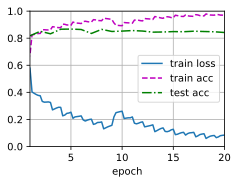

In [ ]:
# usando toda la data

lr, num_epochs = 0.01, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

We define the following function to predict the sentiment of a text sequence using the trained model `net`.


In [ ]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

Finally, let's use the trained model to predict the sentiment for two simple sentences.


In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* Pretrained word vectors can represent individual tokens in a text sequence.
* Bidirectional RNNs can represent a text sequence, such as via the concatenation of its hidden states at the initial and final time steps. This single text representation can be transformed into categories using a fully connected layer.



## Exercises

1. Increase the number of epochs. Can you improve the training and testing accuracies? How about tuning other hyperparameters?
1. Use larger pretrained word vectors, such as 300-dimensional GloVe embeddings. Does it improve classification accuracy?
1. Can we improve the classification accuracy by using the spaCy tokenization? You need to install spaCy (`pip install spacy`) and install the English package (`python -m spacy download en`). In the code, first, import spaCy (`import spacy`). Then, load the spaCy English package (`spacy_en = spacy.load('en')`). Finally, define the function `def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]` and replace the original `tokenizer` function. Note the different forms of phrase tokens in GloVe and spaCy. For example, the phrase token "new york" takes the form of "new-york" in GloVe and the form of "new york" after the spaCy tokenization.


[Discussions](https://discuss.d2l.ai/t/1424)
